# Chef Classifier

## 1. Imports and Setup

In [71]:
import pandas as pd
import ast
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import re
import os
import nltk
from nltk.corpus import wordnet  # for synonyms
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('wordnet')
os.environ["TOKENIZERS_PARALLELISM"] = "False"


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gargoyle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load and Prepare Data

In [72]:
df = pd.read_csv('/Users/gargoyle/Downloads/FINAL TESTING/train.csv', sep=';')
df['tags'] = df['tags'].apply(ast.literal_eval)
df['description'] = df['description'].fillna('')

# aug functions
def get_synonym(word):
    """Return a random synonym using WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            candidate = lemma.name().replace('_', ' ')
            if candidate.lower() != word.lower() and len(candidate.split()) == 1:
                synonyms.add(candidate)
    if synonyms:
        return np.random.choice(list(synonyms))
    return word


def synonym_replace(text, replacement_prob=0.15):
    words = text.split()
    if len(words) < 5:
        return text
    new_words = [
        get_synonym(w) if np.random.rand() < replacement_prob else w
        for w in words
    ]
    return ' '.join(new_words)


def random_delete(text, deletion_prob=0.05):
    words = text.split()
    if len(words) < 5:
        return text
    kept = [w for w in words if np.random.rand() > deletion_prob]
    return ' '.join(kept) if len(kept) > 3 else text


def sentence_shuffle(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    if len(sentences) < 3:
        return text
    np.random.shuffle(sentences)
    return ' '.join(sentences)


def augment_text(text):
    r = np.random.rand()
    if r < 0.5:
        return synonym_replace(text)
    elif r < 0.75:
        return random_delete(text)
    else:
        return sentence_shuffle(text)


def augment_tags(tag_list):
    """Slightly modify tags for diversity (swap or drop)."""
    if not isinstance(tag_list, list) or len(tag_list) == 0:
        return tag_list
    new_tags = tag_list.copy()
    # 10% chance to remove one tag
    if np.random.rand() < 0.1 and len(new_tags) > 1:
        del new_tags[np.random.randint(0, len(new_tags))]
    # 10% chance to duplicate another
    if np.random.rand() < 0.1:
        new_tags.append(np.random.choice(new_tags))
    return list(set(new_tags))


# balancing chef data
def balance_and_augment(df, label_col='chef_id', id_col='orig_id'):
    """Upsample minority chefs with text+tag augmentation, tracking lineage."""
    assert id_col in df.columns, f"{id_col} must be present before augmenting."

    label_counts = df[label_col].value_counts()
    max_count = label_counts.max()
    augmented_rows = []

    print("\nCurrent class distribution:")
    print(label_counts.sort_index())
    print(f"→ Target per class: {max_count}\n")

    for chef, count in label_counts.items():
        if count < max_count:
            n_to_add = max_count - count
            chef_df = df[df[label_col] == chef]
            sampled = chef_df.sample(n=n_to_add, replace=True, random_state=42).copy()

            # lineage + flags
            sampled['parent_id'] = sampled[id_col]
            sampled['is_augmented'] = True

            # apply augments
            sampled['description'] = sampled['description'].apply(augment_text)
            sampled['tags'] = sampled['tags'].apply(augment_tags)

            augmented_rows.append(sampled)
            print(f"↑ Augmented class {chef}: +{n_to_add} samples")

    base = df.copy()
    base['parent_id'] = base[id_col]
    base['is_augmented'] = False

    if augmented_rows:
        df_aug = pd.concat([base] + augmented_rows, ignore_index=True)
        print(f"\nAdded total augmented samples: {sum(len(r) for r in augmented_rows)}")
        print(f"New total dataset size: {len(df_aug)}")
        print("=====================================\n")
        return df_aug
    else:
        print("No augmentation performed — already balanced.\n")
        return base
    
# Split before aug (keep validation clean)
X_raw = df[['description', 'tags', 'chef_id']].copy()

X_train_raw, X_val_raw = train_test_split(
    X_raw, test_size=0.2, random_state=4, stratify=X_raw['chef_id']
)

assert not set(X_train_raw.index).intersection(set(X_val_raw.index)), "Leakage detected between train and val!"


# Reset indices
X_train_raw = X_train_raw.reset_index(drop=True)
X_val_raw = X_val_raw.reset_index(drop=True)
X_train_raw['orig_id'] = X_train_raw.index

print(f"Original training samples: {len(X_train_raw)}")

# aug only training set
X_train_aug = balance_and_augment(X_train_raw)
print(f"Training samples after augmentation: {len(X_train_aug)}")


Original training samples: 2399

Current class distribution:
chef_id
1533    323
3288    361
4470    645
5060    427
6357    298
8688    345
Name: count, dtype: int64
→ Target per class: 645

↑ Augmented class 5060: +218 samples
↑ Augmented class 3288: +284 samples
↑ Augmented class 8688: +300 samples
↑ Augmented class 1533: +322 samples
↑ Augmented class 6357: +347 samples

Added total augmented samples: 1471
New total dataset size: 3870

Training samples after augmentation: 3870


## 3. Generate Embeddings for Descriptions

In [73]:
embedding_model = SentenceTransformer('all-mpnet-base-v2')  # 768 dim

# Encode augmented train and untouched val descriptions
desc_train_emb = embedding_model.encode(X_train_aug['description'].tolist(), show_progress_bar=True)
desc_val_emb   = embedding_model.encode(X_val_raw['description'].tolist(), show_progress_bar=True)

desc_train_emb_df = pd.DataFrame(desc_train_emb, columns=[f'desc_emb_{i}' for i in range(768)], index=X_train_aug.index)
desc_val_emb_df   = pd.DataFrame(desc_val_emb,   columns=[f'desc_emb_{i}' for i in range(768)], index=X_val_raw.index)

# One-hot encode tags
mlb = MultiLabelBinarizer()
tags_train_encoded = mlb.fit_transform(X_train_aug['tags'])
tags_val_encoded   = mlb.transform(X_val_raw['tags'])

tags_train_df = pd.DataFrame(tags_train_encoded, columns=mlb.classes_, index=X_train_aug.index).add_prefix('tag_')
tags_val_df   = pd.DataFrame(tags_val_encoded,   columns=mlb.classes_, index=X_val_raw.index).add_prefix('tag_')

# Combine embeddings + tag features
X_train = pd.concat([desc_train_emb_df, tags_train_df], axis=1)
X_val   = pd.concat([desc_val_emb_df, tags_val_df], axis=1)

y_train = X_train_aug['chef_id'].reset_index(drop=True)
y_val   = X_val_raw['chef_id'].reset_index(drop=True)

train_meta = X_train_aug[['is_augmented', 'parent_id']].copy()
train_meta.index = X_train.index  # ensure identical index alignment

print(f"\nFinal training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")



Batches: 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]


Final training shape: (3870, 1147)
Validation shape: (600, 1147)



/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['burgers', 'catfish', 'collard-greens', 'filipino', 'goose', 'mussels', 'pasta-shells', 'pennsylvania-dutch', 'sourdough', 'turkey-burgers'] will be ignored
  warnings.warn(


## 5. Hyperparameter Tuning

In [74]:
scaler_hp = StandardScaler()
X_train_scaled = scaler_hp.fit_transform(X_train)
X_val_scaled = scaler_hp.transform(X_val)

C_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
results = []

print(f"\nTesting {len(C_values)} C values with lbfgs solver...")
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42, n_jobs=-1, solver='lbfgs')
    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    val_score = model.score(X_val_scaled, y_val)
    results.append({'C': C, 'train_acc': train_score, 'val_acc': val_score, 'gap': train_score - val_score})
    print(f"  C={C:6.3f} | Train: {train_score:.4f} | Val: {val_score:.4f} | Gap: {train_score - val_score:.4f}")

results_df = pd.DataFrame(results)
best_idx = results_df['val_acc'].idxmax()
best_C = results_df.loc[best_idx, 'C']

print("\n" + "=" * 60)
print(f"Best C: {best_C}")
print(f"Best validation accuracy: {results_df.loc[best_idx, 'val_acc']:.4f}")
print("=" * 60)


Testing 7 C values with lbfgs solver...
  C= 0.001 | Train: 0.9426 | Val: 0.8400 | Gap: 0.1026
  C= 0.005 | Train: 0.9835 | Val: 0.8583 | Gap: 0.1251
  C= 0.010 | Train: 0.9917 | Val: 0.8567 | Gap: 0.1351
  C= 0.050 | Train: 1.0000 | Val: 0.8500 | Gap: 0.1500
  C= 0.100 | Train: 1.0000 | Val: 0.8450 | Gap: 0.1550
  C= 0.500 | Train: 1.0000 | Val: 0.8350 | Gap: 0.1650
  C= 1.000 | Train: 1.0000 | Val: 0.8317 | Gap: 0.1683

Best C: 0.005
Best validation accuracy: 0.8583


## 6. K-Fold Cross Validation


Leakage-proof CV (val=originals only, train=originals(excl. fold) + augmented not derived from val):
  Fold 1: 0.8633 (86.33%)
  Fold 2: 0.8633 (86.33%)
  Fold 3: 0.8400 (84.00%)
  Fold 4: 0.8633 (86.33%)
  Fold 5: 0.8033 (80.33%)
  Fold 6: 0.8567 (85.67%)
  Fold 7: 0.8400 (84.00%)
  Fold 8: 0.8428 (84.28%)
--------------------
Mean: 0.8466 (84.66%)
Std:  0.0191 (1.91%)
Min:  0.8033 (80.33%)
Max:  0.8633 (86.33%)


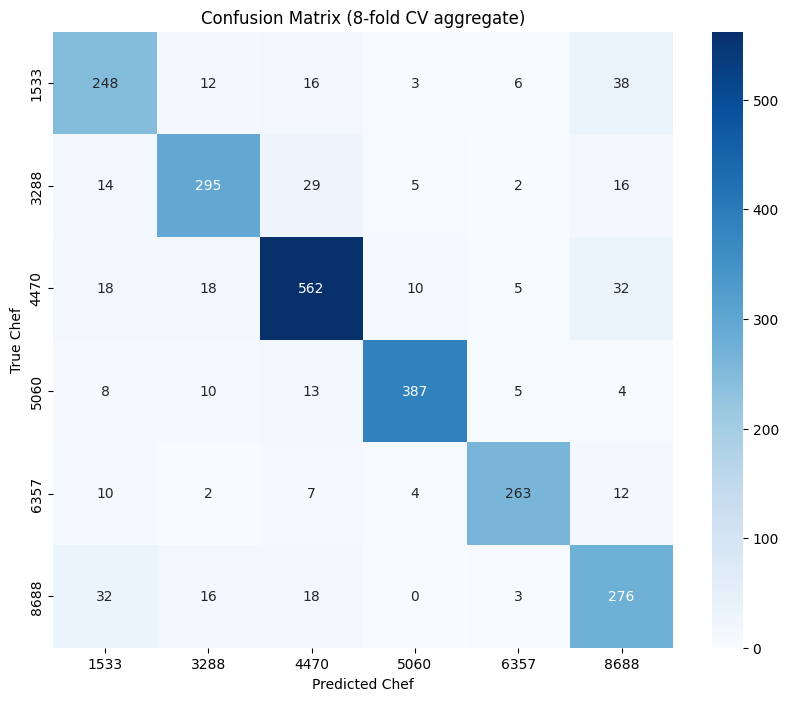


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        1533     0.7515    0.7678    0.7596       323
        3288     0.8357    0.8172    0.8263       361
        4470     0.8713    0.8713    0.8713       645
        5060     0.9462    0.9063    0.9258       427
        6357     0.9261    0.8826    0.9038       298
        8688     0.7302    0.8000    0.7635       345

    accuracy                         0.8466      2399
   macro avg     0.8435    0.8409    0.8417      2399
weighted avg     0.8497    0.8466    0.8477      2399


TP / FP / TN / FN STATS PER CLASS
Class 1533: TP=248, FP=82, TN=1994, FN=75
Class 3288: TP=295, FP=58, TN=1980, FN=66
Class 4470: TP=562, FP=83, TN=1671, FN=83
Class 5060: TP=387, FP=22, TN=1950, FN=40
Class 6357: TP=263, FP=21, TN=2080, FN=35
Class 8688: TP=276, FP=102, TN=1952, FN=69


In [75]:

# Originals only for validation candidates
orig_mask = ~train_meta['is_augmented']
orig_idx = X_train.index[orig_mask]

X_orig = X_train.loc[orig_idx]
y_orig = y_train.loc[orig_idx]

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
fold_scores = []
all_preds = []
all_true = []

print("\nLeakage-proof CV (val=originals only, train=originals(excl. fold) + augmented not derived from val):")
for fold, (tr_i, va_i) in enumerate(skf.split(X_orig, y_orig), 1):
    val_idx = X_orig.index[va_i]          # original rows for validation
    tr_orig_idx = X_orig.index[tr_i]      # original rows for training

    # augmented rows whose parent is NOT in validation fold
    aug_ok_mask = (train_meta['is_augmented']) & (~train_meta['parent_id'].isin(val_idx))
    tr_aug_idx = X_train.index[aug_ok_mask]

    # final train = originals (train part) + safe augmented
    tr_idx_all = tr_orig_idx.union(tr_aug_idx)

    X_tr = X_train.loc[tr_idx_all]
    y_tr = y_train.loc[tr_idx_all]
    X_va = X_train.loc[val_idx]
    y_va = y_train.loc[val_idx]

    # scale **from training only**
    scaler_cv = StandardScaler()
    X_tr_s = scaler_cv.fit_transform(X_tr)
    X_va_s = scaler_cv.transform(X_va)

    model_cv = LogisticRegression(C=best_C, max_iter=1000, random_state=42, n_jobs=-1, solver='lbfgs')
    model_cv.fit(X_tr_s, y_tr)
    preds = model_cv.predict(X_va_s)

    all_preds.extend(preds)
    all_true.extend(y_va)

    acc = accuracy_score(y_va, preds)
    fold_scores.append(acc)
    print(f"  Fold {fold}: {acc:.4f} ({acc:.2%})")

print("-" * 20)
print(f"Mean: {np.mean(fold_scores):.4f} ({np.mean(fold_scores):.2%})")
print(f"Std:  {np.std(fold_scores):.4f} ({np.std(fold_scores):.2%})")
print(f"Min:  {np.min(fold_scores):.4f} ({np.min(fold_scores):.2%})")
print(f"Max:  {np.max(fold_scores):.4f} ({np.max(fold_scores):.2%})")

# ===========================
# CONFUSION MATRIX + METRICS
# ===========================

# Convert to numpy arrays
all_true = np.array(all_true)
all_preds = np.array(all_preds)

labels_sorted = np.unique(y_train)
cm = confusion_matrix(all_true, all_preds, labels=labels_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted Chef")
plt.ylabel("True Chef")
plt.title("Confusion Matrix (8-fold CV aggregate)")
plt.show()

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(all_true, all_preds, digits=4))

# ===========================
# TP, FP, TN, FN per class
# ===========================
print("\n" + "=" * 60)
print("TP / FP / TN / FN STATS PER CLASS")
print("=" * 60)

for i, cls in enumerate(labels_sorted):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"Class {cls}: TP={TP}, FP={FP}, TN={TN}, FN={FN}")

In [76]:
# ============================================================
#  FINAL TRAINING ON FULL (AUGMENTED) DATASET + TEST INFERENCE
# ============================================================

print("\n" + "=" * 60)
print("FINAL TRAINING ON FULL DATASET (WITH AUGMENTATION)")
print("=" * 60)

# reload training data
df_full = pd.read_csv('/Users/gargoyle/Downloads/FINAL TESTING/train.csv', sep=';')
df_full['tags'] = df_full['tags'].apply(ast.literal_eval)
df_full['description'] = df_full['description'].fillna('')

# balance_and_augment lineage tracking
df_full = df_full.reset_index(drop=True)
df_full['orig_id'] = df_full.index

# augment for class balance
df_full_aug = balance_and_augment(df_full)
print(f"Final training set after augmentation: {len(df_full_aug)} samples\n")

# embed and encode
embedding_model = SentenceTransformer('all-mpnet-base-v2')

desc_emb_full = embedding_model.encode(df_full_aug['description'].tolist(), show_progress_bar=True)
desc_emb_full_df = pd.DataFrame(
    desc_emb_full,
    columns=[f'desc_emb_{i}' for i in range(768)],
    index=df_full_aug.index
)

mlb_full = MultiLabelBinarizer()
tags_encoded_full = mlb_full.fit_transform(df_full_aug['tags'])
tags_full_df = pd.DataFrame(tags_encoded_full, columns=mlb_full.classes_, index=df_full_aug.index).add_prefix('tag_')

X_full = pd.concat([desc_emb_full_df, tags_full_df], axis=1)
y_full = df_full_aug['chef_id']

# scale and train
scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

final_model = LogisticRegression(
    C=best_C, max_iter=1000, random_state=42, n_jobs=-1, solver='lbfgs'
)
final_model.fit(X_full_scaled, y_full)

print("\nFinal model trained successfully on full dataset.")

# ============================================================
#  INFERENCE ON TEST SET
# ============================================================

print("\n" + "=" * 60)
print("RUNNING INFERENCE ON TEST SET")
print("=" * 60)

# load test set
test_path = '/Users/gargoyle/Downloads/FINAL TESTING/test-no-labels.csv'
df_test = pd.read_csv(test_path, sep=';')
df_test['tags'] = df_test['tags'].apply(ast.literal_eval)
df_test['description'] = df_test['description'].fillna('')

# embed test descr
desc_test_emb = embedding_model.encode(df_test['description'].tolist(), show_progress_bar=True)
desc_test_emb_df = pd.DataFrame(desc_test_emb, columns=[f'desc_emb_{i}' for i in range(768)], index=df_test.index)

tags_test_encoded = mlb_full.transform(df_test['tags'])
tags_test_df = pd.DataFrame(tags_test_encoded, columns=mlb_full.classes_, index=df_test.index).add_prefix('tag_')

X_test = pd.concat([desc_test_emb_df, tags_test_df], axis=1)
X_test_scaled = scaler_final.transform(X_test)

pred_labels = final_model.predict(X_test_scaled)

# ============================================================
#  SAVE PREDICTIONS
# ============================================================

results_path = "results.txt"
with open(results_path, "w", encoding="utf-8") as f:
    f.write("\n")  # offset by 1 line for automatic testing
    f.write("\n".join(str(label) for label in pred_labels))

print(f"\nPredictions saved to {results_path}")
print(f"Total predictions: {len(pred_labels)}")



FINAL TRAINING ON FULL DATASET (WITH AUGMENTATION)

Current class distribution:
chef_id
1533    404
3288    451
4470    806
5060    534
6357    372
8688    432
Name: count, dtype: int64
→ Target per class: 806

↑ Augmented class 5060: +272 samples
↑ Augmented class 3288: +355 samples
↑ Augmented class 8688: +374 samples
↑ Augmented class 1533: +402 samples
↑ Augmented class 6357: +434 samples

Added total augmented samples: 1837
New total dataset size: 4836

Final training set after augmentation: 4836 samples



Batches: 100%|██████████| 152/152 [00:48<00:00,  3.12it/s]



Final model trained successfully on full dataset.

RUNNING INFERENCE ON TEST SET


Batches: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


Predictions saved to results.txt
Total predictions: 823



/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['bok-choys', 'dairy-free', 'manicotti', 'native-american', 'trout'] will be ignored
  warnings.warn(
